In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gunamunidilshi","key":"72d8f6d26347ee6e415138191a99d740"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.10G/3.10G [00:22<00:00, 223MB/s]
100% 3.10G/3.10G [00:22<00:00, 146MB/s]


In [ ]:
!unzip breast-histopathology-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2251_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2301_class0.png  
  inflating: IDC_regular_

In [ ]:
mkdir /content/train_data

In [ ]:
mkdir /content/train_data/benign

In [ ]:
mkdir /content/train_data/malignant

In [ ]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 26.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
import tensorflow as tf
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Flatten
import matplotlib.pyplot as plt
import pickle
import PIL
from PIL import Image
from math import exp, tanh
from tokenize import Exponent
from enum import Enum
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from datetime import date
from io import BytesIO
from IPython import display
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import base64
import pandas as pd
import seaborn as sns
import uuid
import glob
import shutil

<ipython-input-5-7daa45a7bd28>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [ ]:
#create benign image dataset without duplicates

# Get all png files from group of folders
png_files = glob.glob("/content/**/0/*.png", recursive=True)[:20000]

# Move the png files to the dataset folder and filter duplicates
for png_file in png_files:
    if not os.path.exists("/content/train_data/benign/" + os.path.basename(png_file)):
        shutil.move(png_file, "/content/train_data/benign/")

In [ ]:
#create malignant image dataset without duplicates

# Get all png files in group of folders
png_files = glob.glob("/content/**/1/*.png", recursive=True)[:20000]

# Move the png files to the dataset folder
for png_file in png_files:
    if not os.path.exists("/content/train_data/malignant/" + os.path.basename(png_file)):
        shutil.move(png_file, "/content/train_data/malignant/")

In [ ]:
data_dir= "/content/train_data"

In [ ]:
batch_size = 32
img_height = 50
img_width = 50

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
)

Found 40000 files belonging to 2 classes.
Using 32000 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
)

Found 40000 files belonging to 2 classes.
Using 8000 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['benign', 'malignant']


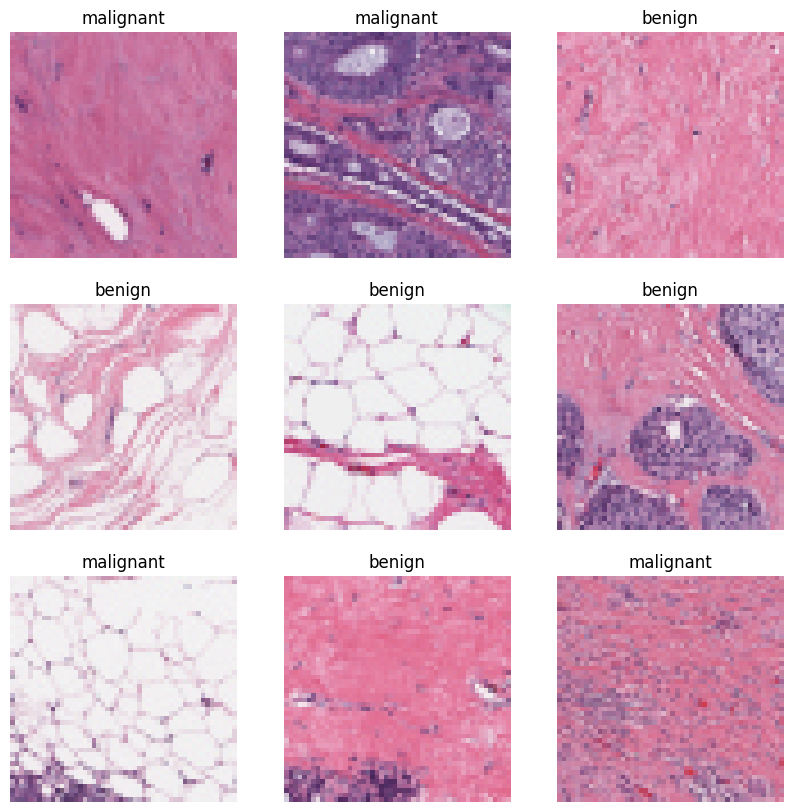

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
      print(image_batch.shape)
      print(labels_batch.shape)
      break

(32, 50, 50, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.121568635 0.9568628


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 50, 50, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 50, 50, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        1

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
1000/1000 [==============================] - 100s 98ms/step - loss: 0.4786 - accuracy: 0.7764 - val_loss: 0.4316 - val_accuracy: 0.8129
Epoch 2/10
1000/1000 [==============================] - 95s 95ms/step - loss: 0.4211 - accuracy: 0.8156 - val_loss: 0.4025 - val_accuracy: 0.8242
Epoch 3/10
1000/1000 [==============================] - 93s 93ms/step - loss: 0.3975 - accuracy: 0.8277 - val_loss: 0.4204 - val_accuracy: 0.8188
Epoch 4/10
1000/1000 [==============================] - 96s 96ms/step - loss: 0.3864 - accuracy: 0.8326 - val_loss: 0.3708 - val_accuracy: 0.8403
Epoch 5/10
1000/1000 [==============================] - 87s 87ms/step - loss: 0.3675 - accuracy: 0.8407 - val_loss: 0.4297 - val_accuracy: 0.8127
Epoch 6/10
1000/1000 [==============================] - 89s 89ms/step - loss: 0.3588 - accuracy: 0.8460 - val_loss: 0.3670 - val_accuracy: 0.8424
Epoch 7/10
1000/1000 [==============================] - 89s 89ms/step - loss: 0.3445 - accuracy: 0.8517 - val_loss: 0.3580 

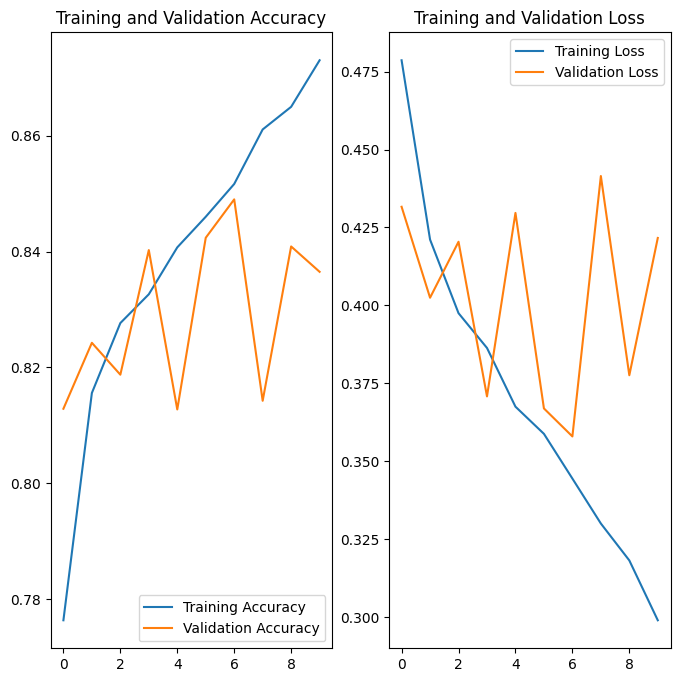

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

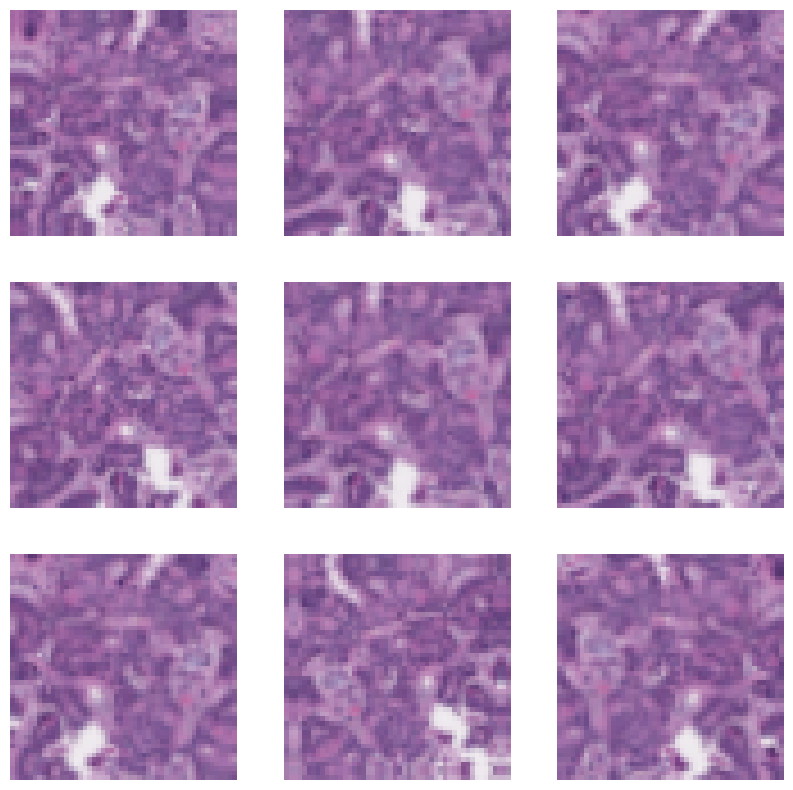

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 50, 50, 3)         0         
                                                                 
 rescaling_2 (Rescaling)     (None, 50, 50, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 25, 25, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 12, 12, 32)        0         
 g2D)                                                 

In [39]:
  epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
1000/1000 [==============================] - 121s 119ms/step - loss: 0.5014 - accuracy: 0.7677 - val_loss: 0.4346 - val_accuracy: 0.8161
Epoch 2/20
1000/1000 [==============================] - 112s 112ms/step - loss: 0.4401 - accuracy: 0.8062 - val_loss: 0.4150 - val_accuracy: 0.8217
Epoch 3/20
1000/1000 [==============================] - 113s 113ms/step - loss: 0.4185 - accuracy: 0.8184 - val_loss: 0.5887 - val_accuracy: 0.7041
Epoch 4/20
1000/1000 [==============================] - 108s 108ms/step - loss: 0.4009 - accuracy: 0.8288 - val_loss: 0.3789 - val_accuracy: 0.8356
Epoch 5/20
1000/1000 [==============================] - 110s 110ms/step - loss: 0.3969 - accuracy: 0.8291 - val_loss: 0.4134 - val_accuracy: 0.8234
Epoch 6/20
1000/1000 [==============================] - 119s 119ms/step - loss: 0.3838 - accuracy: 0.8356 - val_loss: 0.3660 - val_accuracy: 0.8432
Epoch 7/20
1000/1000 [==============================] - 108s 108ms/step - loss: 0.3807 - accuracy: 0.8368 - val_

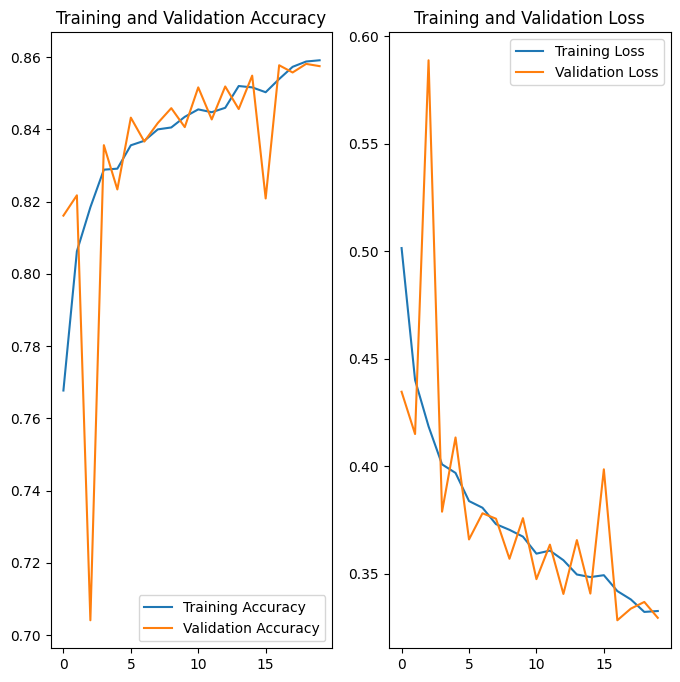

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
DATADIR = "/content/10254/1/10254_idx5_x1601_y1301_class1.png"

In [42]:
img = tf.keras.utils.load_img(
    DATADIR, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 139ms/step
This image most likely belongs to malignant with a 99.13 percent confidence.
